In [331]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [332]:
from pandas import Series
import pandas as pd
import datetime
# import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA


# from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from math import log as log
from math import log1p as log1p
import os

# 1. Смотрим на признаки

In [333]:
path = './sf-dst-scoring'

In [334]:
train = pd.read_csv(path +'/train.csv')
test = pd.read_csv(path +'/test.csv')
sample_sub = pd.read_csv(path +'/sample_submission.csv')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [335]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

### Описание данных:

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

In [336]:
# В конечном счете не стал объединять test и train.

# Объединяем тренировочные и тестовые данные в один датасет
# train['train'] = 1 # помечаем тренировочные
# test['train'] = 0 # помечаем тестовые
# train = pd.concat([train, test], ignore_index=True)
# train.info()

In [337]:
def describe_column(df, c, ncb='num'):
    if ncb == 'num':
        describe_num_column(df, c)
        return
    elif ncb == 'cat':
        describe_cat_column(df, c)
        return
    elif ncb == 'bin':
        print('bin')     
        return  
    else:
        print('Function describe_column: Unknown TYPE ERROR -', ncb)
        return

    
def describe_num_column(df, c):
    n = np.shape(df)[0] # всего строк в df
    different_value_n = len(df[c].value_counts()) # Кол-во различающихся значений
        
    minimum = df[c].min()
    maximum = df[c].max()
    mean = df[c].mean()
    median = df[c].median()
    std = df[c].std()
        
    Q1 = df[c].quantile(0.25)
    Q3 = df[c].quantile(0.75)
    IQR = Q3 - Q1
    outliers_l = Q1 - 1.5 * IQR
    outliers_r = Q3 + 1.5 * IQR

    mean_default_0 = df[c][df.default == 0].mean()
    mean_default_1 = df[c][df.default == 1].mean()
    median_default_0 = df[c][df.default == 0].median()
    median_default_1 = df[c][df.default == 1].median()
        
    print(f"Колонка '{c}'")
    print(f"==========", len(c)*"=", sep='')
    print(f"   Всего значений {n}, из них различных {different_value_n}\n")
    print(f"   Минимум = {minimum}, Максимум = {maximum}")
    print(f"   Среднее = {round(mean, 1)}\n   Медиана = {round(median, 1)}")
    print(f"   Стандартное отклонение = {round(std, 1)}\n")
    print(f"   Анализ выбросов:\n    Q1 = {round(Q1, 1)}, Q3 = {round(Q3, 1)}, IQR = {round(IQR, 1)}")
    print(f"    Границы выбросов: левая {round(outliers_l, 1)}, правая {round(outliers_r, 1)}")
    
    if outliers_l <= minimum and outliers_r >= maximum:
        print("    Выбросов нет :-)\n")
    else:
        df_tmp = df[(df[c] < outliers_l) | (df[c] > outliers_r)]
        outliers_number = np.shape(df_tmp)[0]
        print(f"    Количество выбросов: {outliers_number} из {n} ({round(outliers_number/n*100, 1)}%)\n")
        
    print(f"   Связь между параметрами '{c}' и 'default':")
    print(f"    Среднее для дефолтных (стрёмных) клиентов {round(mean_default_1, 1)}")
    print(f"    Среднее для НЕдефолтных (годных) клиентов {round(mean_default_0, 1)}")
    print(f"    Медиана для дефолтных (стрёмных) клиентов {round(median_default_1, 1)}")
    print(f"    Медиана для НЕдефолтных (годных) клиентов {round(median_default_0, 1)}")
    
    return
        
def describe_cat_column(df, c):
    # Извлекаем список категорий
    category_list = list(df[c].value_counts().index)
    category_list.sort() # в принципе можно и не сортировать

    for category in category_list:
        # Берем заданную категорию из датасета
        filtered = train[df[c] == category]
    
        # Считаем общее кол-во клиентов в заданной категории
        n = filtered.client_id.count()
    
        # Считаем кол-во дефолтных и недефолтных клиентов в заданной категории
        clients_n_def0 = filtered[filtered.default == 0].client_id.count()
        clients_n_def1 = filtered[filtered.default == 1].client_id.count()

        # Красиво печатаем наши результаты наших изысканий
        print(f"Всего {n} клиентов в категории \'{category}\' - ", end = '')
        print(f"{round(n/len(df)*100, 1)}% от общего числа клиентов")
        print(f"Из них: ", end = "")
        print(f"{clients_n_def1} ({round(clients_n_def1/n*100, 1)}%) дефолтных и ", end = '')
        print(f"{clients_n_def0} ({round(clients_n_def0/n*100, 1)}%) недефолтных\n")
    
    sns.displot(df[c], kind= "hist", color='tab:pink') # kind = {"hist", "kde", "ecdf"}
    train.pivot_table(values=['default'],
                      index=c,
                      aggfunc='mean').plot(kind='bar', 
                                           title='Proportion of default clients vs. ' + c)
    return


def strange_tail(df, c, events_limit=10):
    # events_limit - количество событий, больше которого становится "всё страньше и страньше"

    # фильтруем людей с кол-вом событий больше нашего лимита 
    filtered = df[(df[c] > events_limit)]
    stgange_number = len(filtered) #  кол-во таких "странных" людей

    print(f"Клиентов с более, чем {events_limit} событиями:")
    print(f"   {stgange_number} из {len(train)} ({round(stgange_number/len(train)*100, 2)}%)")

    # Сколько из этих "странных" дефолтных и недефолтных
    def_0 = filtered[filtered.default == 0].client_id.count()
    def_1 = filtered[filtered.default == 1].client_id.count()
    
    print(f"Из этих {stgange_number}:")
    print(f"   дефолтных {def_1} ({round(def_1/stgange_number*100, 1)}%)")
    print(f"   недефолтных {def_0} ({round(def_0/stgange_number*100, 1)}%)\n")

## 1.1. 'age' - возраст, числовой

In [338]:
describe_column(train, 'age')

Колонка 'age'
   Всего значений 73799, из них различных 52

   Минимум = 21, Максимум = 72
   Среднее = 39.3
   Медиана = 37.0
   Стандартное отклонение = 11.5

   Анализ выбросов:
    Q1 = 30.0, Q3 = 48.0, IQR = 18.0
    Границы выбросов: левая 3.0, правая 75.0
    Выбросов нет :-)

   Связь между параметрами 'age' и 'default':
    Среднее для дефолтных (стрёмных) клиентов 38.5
    Среднее для НЕдефолтных (годных) клиентов 39.4
    Медиана для дефолтных (стрёмных) клиентов 36.0
    Медиана для НЕдефолтных (годных) клиентов 38.0


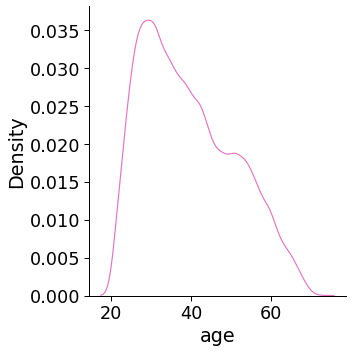

In [339]:
sns.displot(train.age, kind= "kde", color='tab:pink') # kind = {"hist", "kde", "ecdf"}

###  Краткие выводы о колонке 'age'

- Пропусков и выбросов нет
- Распределение с тяжелым правым хвостом - молодые более склонны брать кредиты
- Возраст дефолтных клиентов в среднем ниже: 38.5 против 39.4 у недефолтных
- Медиана возраста у дефолтных ниже: 36 против 38

### Что можно сделать с колонкой 'age'?

- Пока ничего не буду делать
- Потом можно попробовать логарифмировать, хотя распределение логарифма не сказать, что сильно отличается

## 1.2. Колонка 'decline_app_cnt' - количество отказанных прошлых заявок - числовой признак

In [340]:
describe_column(train, 'decline_app_cnt')

Колонка 'decline_app_cnt'
   Всего значений 73799, из них различных 21

   Минимум = 0, Максимум = 33
   Среднее = 0.3
   Медиана = 0.0
   Стандартное отклонение = 0.8

   Анализ выбросов:
    Q1 = 0.0, Q3 = 0.0, IQR = 0.0
    Границы выбросов: левая 0.0, правая 0.0
    Количество выбросов: 12585 из 73799 (17.1%)

   Связь между параметрами 'decline_app_cnt' и 'default':
    Среднее для дефолтных (стрёмных) клиентов 0.5
    Среднее для НЕдефолтных (годных) клиентов 0.2
    Медиана для дефолтных (стрёмных) клиентов 0.0
    Медиана для НЕдефолтных (годных) клиентов 0.0


In [341]:
train.decline_app_cnt.value_counts()

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
24        1
15        1
19        1
22        1
33        1
Name: decline_app_cnt, dtype: int64

In [342]:
strange_tail(train, 'decline_app_cnt')

Клиентов с более, чем 10 событиями:
   23 из 73799 (0.03%)
Из этих 23:
   дефолтных 7 (30.4%)
   недефолтных 16 (69.6%)



### Наблюдения о колонке 'decline_app_cnt'

- Первое впечатление от признака 'decline_app_cnt' - непонятно, что это за люди такие, которые получают много отказов, но при этом продолжают снова и снова обращаться в банк за кредитом. Особенно из этой группы странных людей удивляют __недефолтные__, то есть те, кому вроде как можно бы и дать кредит.

- Как мы видим, у 33 человек кол-во отказов более 10, из них недефолтных аж целых 16. Вот уж дейстивтельно странные люди...

- Еще наблюдение - в данном случае медиана и границы выбросов совпадают, то есть всё, что не равно 0 является выбросами.

- Это всё лирика, сделать признак категориальным по принципу "раз, два, три, много".

In [343]:
# избавляемся от клиентов с большим кол-вом отказов
# train = train[(train.decline_app_cnt <= 10)]

# describe_column(train, 'decline_app_cnt')

Картина не сильно изменилась. Попробуем прологарифмировать.

In [344]:
# train['decline_app_cnt'] = train['decline_app_cnt'].apply(log1p)

# describe_column(train, 'decline_app_cnt')

Те же лыжи, только в профиль.

### Что можно ещё сделать с колонкой 'decline_app_cnt'

- Пока больше ничего не буду делать
- На будущее, если время будет: сделать признак категориальным по принципу "раз, два, три, много".

## 1.3. 'score_bki' - скоринговый балл по данным из БКИ, числовой

In [345]:
describe_column(train, 'score_bki')

Колонка 'score_bki'
   Всего значений 73799, из них различных 69096

   Минимум = -3.62458632, Максимум = 0.19977285
   Среднее = -1.9
   Медиана = -1.9
   Стандартное отклонение = 0.5

   Анализ выбросов:
    Q1 = -2.3, Q3 = -1.6, IQR = 0.7
    Границы выбросов: левая -3.3, правая -0.5
    Количество выбросов: 351 из 73799 (0.5%)

   Связь между параметрами 'score_bki' и 'default':
    Среднее для дефолтных (стрёмных) клиентов -1.7
    Среднее для НЕдефолтных (годных) клиентов -1.9
    Медиана для дефолтных (стрёмных) клиентов -1.7
    Медиана для НЕдефолтных (годных) клиентов -2.0


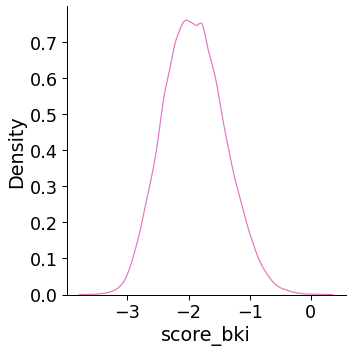

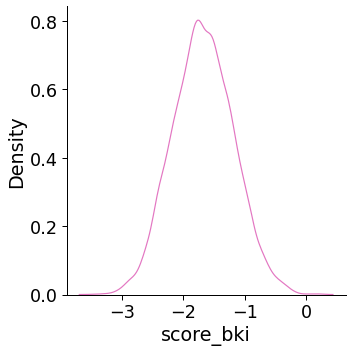

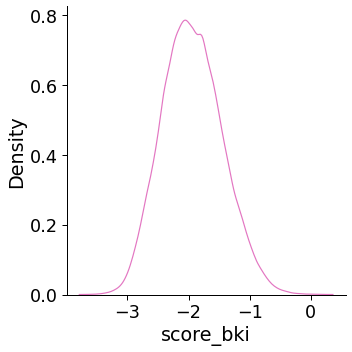

In [346]:
sns.displot(train.score_bki, kind= "kde", color='tab:pink') # kind = {"hist", "kde", "ecdf"}
sns.displot(train[train.default == 1].score_bki, kind= "kde", color='tab:pink') # kind = {"hist", "kde", "ecdf"}
sns.displot(train[train.default == 0].score_bki, kind= "kde", color='tab:pink') # kind = {"hist", "kde", "ecdf"}

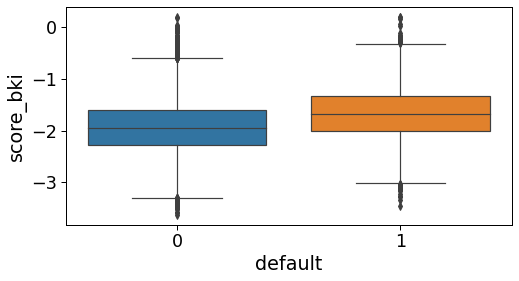

In [347]:
fig, axes = plt.subplots(figsize = (8, 4))

sns.boxplot(x='default', y='score_bki', data=train, orient="v")

plt.show()

#         sns.boxplot(x='default', y=c, data=df, ax=axes)
#         axes.set_title('\'' + c + '\'' + ' Boxplot')
#         plt.show()

###  Краткие выводы о колонке 'score_bki'

- Пропусков нет 
- Выбросов не более 0.5%
- Распределение визуально нормальное
- У дефолтных клиентов средний скоринговый балл ниже: -1.7 против -1,9 у недефолтных

### Что можно сделать с колонкой 'score_bki'?

- Пока ничего не буду делать
- Потом можно будет попробовать удалить 0.5% выбросов

## 1.4. 'income' - доход заемщика, числовой

In [348]:
describe_column(train, 'income')

Колонка 'income'
   Всего значений 73799, из них различных 966

   Минимум = 1000, Максимум = 1000000
   Среднее = 41099.8
   Медиана = 30000.0
   Стандартное отклонение = 46166.3

   Анализ выбросов:
    Q1 = 20000.0, Q3 = 48000.0, IQR = 28000.0
    Границы выбросов: левая -22000.0, правая 90000.0
    Количество выбросов: 4695 из 73799 (6.4%)

   Связь между параметрами 'income' и 'default':
    Среднее для дефолтных (стрёмных) клиентов 36288.1
    Среднее для НЕдефолтных (годных) клиентов 41799.7
    Медиана для дефолтных (стрёмных) клиентов 28000.0
    Медиана для НЕдефолтных (годных) клиентов 30000.0


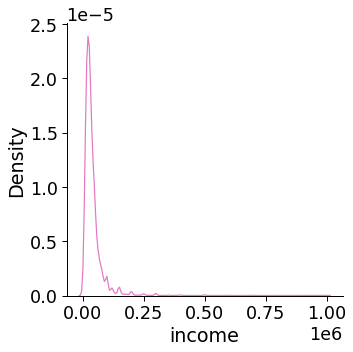

In [349]:
sns.displot(train.income, kind= "kde", color='tab:pink') # kind = {"hist", "kde", "ecdf"}

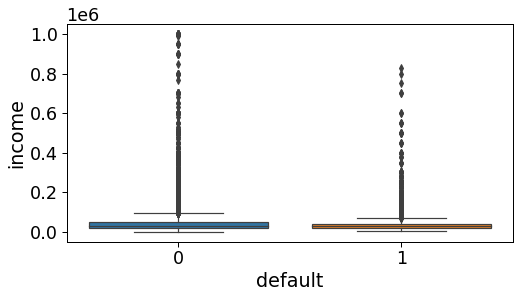

In [350]:
fig, axes = plt.subplots(figsize = (8, 4))
sns.boxplot(x='default', y='income', data=train, orient="v")
plt.show()

###  Краткие выводы о колонке 'income'

- Пропусков нет 
- Выбросов 6.4%
- Распределение визуально далеко от нормального
- Boxplot малоинформативен из-за сильного разброса
- У дефолтных клиентов средний доход ниже: 36292 против клиентов 41795 у недефолтных

### Давайте-ка прологарифмируем 'income' для уменьшения разброса 

In [351]:
# train['income'] = train['income'].apply(log1p)

# describe_column(train, 'income')

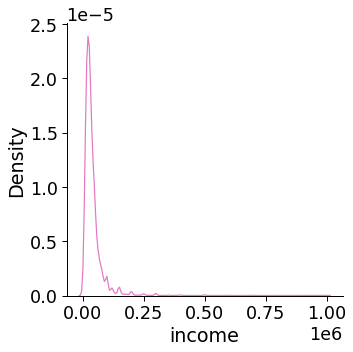

In [352]:
sns.displot(train.income, kind= "kde", color='tab:pink') # kind = {"hist", "kde", "ecdf"}

### Что с колонкой 'income' после логарифмирования?

- Кол-во выбросов уменьшилось с 6.4% до 2.4%
- Распределение визуально стало похожим на нормальное
- На этом пока что остановимся, хотя можно подумать, не удалить ли оставшиеся 2.4% выбросов?...

## 1.5. 'bki_request_cnt' - количество запросов в БКИ, числовой

In [353]:
describe_column(train, 'bki_request_cnt')

Колонка 'bki_request_cnt'
   Всего значений 73799, из них различных 38

   Минимум = 0, Максимум = 53
   Среднее = 2.0
   Медиана = 1.0
   Стандартное отклонение = 2.3

   Анализ выбросов:
    Q1 = 0.0, Q3 = 3.0, IQR = 3.0
    Границы выбросов: левая -4.5, правая 7.5
    Количество выбросов: 1755 из 73799 (2.4%)

   Связь между параметрами 'bki_request_cnt' и 'default':
    Среднее для дефолтных (стрёмных) клиентов 2.5
    Среднее для НЕдефолтных (годных) клиентов 1.9
    Медиана для дефолтных (стрёмных) клиентов 2.0
    Медиана для НЕдефолтных (годных) клиентов 1.0


In [354]:
train.bki_request_cnt.value_counts()

0     19381
1     18276
2     13749
3      9187
4      5627
5      3268
6      1704
7       852
8       508
9       299
10      225
11      188
12      144
13       94
14       86
15       54
16       35
18       22
17       19
19       18
21       12
24       11
20        9
23        7
28        4
22        4
32        2
27        2
26        2
25        2
46        1
29        1
33        1
34        1
36        1
41        1
45        1
53        1
Name: bki_request_cnt, dtype: int64

In [355]:
strange_tail(train, 'bki_request_cnt', 10)
strange_tail(train, 'bki_request_cnt', 15)
strange_tail(train, 'bki_request_cnt', 25)

Клиентов с более, чем 10 событиями:
   723 из 73799 (0.98%)
Из этих 723:
   дефолтных 188 (26.0%)
   недефолтных 535 (74.0%)

Клиентов с более, чем 15 событиями:
   157 из 73799 (0.21%)
Из этих 157:
   дефолтных 48 (30.6%)
   недефолтных 109 (69.4%)

Клиентов с более, чем 25 событиями:
   18 из 73799 (0.02%)
Из этих 18:
   дефолтных 8 (44.4%)
   недефолтных 10 (55.6%)



### Наблюдения о колонке 'bki_request_cnt'

- Ситуация аналогична ситуации с признаком 'decline_app_cnt' - непонятно, что это за люди, по которы делается такое большое количество запросов в БКИ? Причем среди таких людей примерно 25-30% дефолтных.
- Среднее для дефолтных (стрёмных) клиентов 2.5, для НЕдефолтных (годных) клиентов 1.9
- Я не вполне понимаю физический смысл такого количества запросов.
- В общем очень хочется удалить всех, для кого количество запросов больше какого-то порогового занчения.
- Если будет время, можно поиграться с логарифмированием и удалением выбросов.

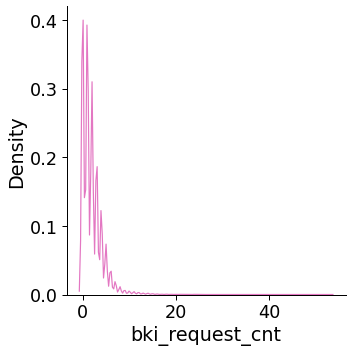

In [356]:
sns.displot(train.bki_request_cnt, kind= "kde", color='tab:pink') # kind = {"hist", "kde", "ecdf"}

In [357]:
# log_column(train, 'bki_request_cnt')
# sns.displot(train.bki_request_cnt, kind= "hist", color='tab:pink') # kind = {"hist", "kde", "ecdf"}

In [358]:
# fig, axes = plt.subplots(figsize = (8, 4))
# sns.boxplot(x='default', y='bki_request_cnt', data=train, orient="v")
# plt.show()

## 1.6. 'region_rating' - количество запросов в БКИ, выглядит как числовой, но по факту ординальный

Всего 206 клиентов в категории '20' - 0.3% от общего числа клиентов
Из них: 44 (21.4%) дефолтных и 162 (78.6%) недефолтных

Всего 300 клиентов в категории '30' - 0.4% от общего числа клиентов
Из них: 57 (19.0%) дефолтных и 243 (81.0%) недефолтных

Всего 12027 клиентов в категории '40' - 16.3% от общего числа клиентов
Из них: 2041 (17.0%) дефолтных и 9986 (83.0%) недефолтных

Всего 27523 клиентов в категории '50' - 37.3% от общего числа клиентов
Из них: 3747 (13.6%) дефолтных и 23776 (86.4%) недефолтных

Всего 16075 клиентов в категории '60' - 21.8% от общего числа клиентов
Из них: 2071 (12.9%) дефолтных и 14004 (87.1%) недефолтных

Всего 6199 клиентов в категории '70' - 8.4% от общего числа клиентов
Из них: 573 (9.2%) дефолтных и 5626 (90.8%) недефолтных

Всего 11469 клиентов в категории '80' - 15.5% от общего числа клиентов
Из них: 839 (7.3%) дефолтных и 10630 (92.7%) недефолтных



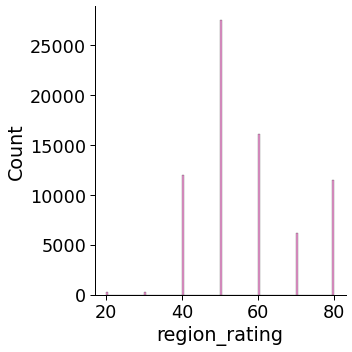

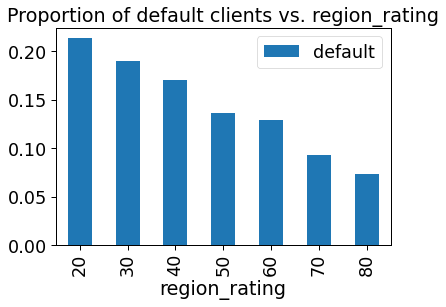

In [359]:
describe_column(train, 'region_rating', 'cat')

### Наблюдения о колонке 'region_rating'

- по факту это ординальный признак - значений всего 7 - от 20 до 80
- регионов с рейтингом 20 и 30 очень немного - 505 или 0.7% от всего количества
- Средний 'region_rating' для дефолтных клиентов 53.7, для годных клиентов 57.2
- Примерный физический смысл 'region_rating' - чем ниже рейтинг региона, тем больше дефолтных клиентов

### На будущее:
- Попробовать удалить клиентов из регионов с рейтингом 20 и 30, и посмотреть, как это скажется на показателях модели.
- Посмотрел на графики - нет, удалять клиентов не надо. Надо просто не давать им кредитов вовсе :-)
- Также попробовать перекодировать - что это за числа [20, 30, ..., 80]. А почему не [1,2,3,4,5,6,7]? Вообще, модель как на такую перекодировку среагирует?

## 1.7. 'education' - уровень образования, категориальный-ординальный

Не понятно, конечно, об образовании в какой стране идет речь, но покопавшись в инете расшифровал примерно так

- SCH (school) школьное образование
- UGR (undergraduate) базовое высшее с получением степени бакалавра
- GRD (graduate) базовое высшее с получением степени магистра
- PGR (postgraduate) профессиональная специализация
- ACD (academic degree)

_Взято у Sergey Meshcheryakov meshcheryakovsvru@yandex.ru_

In [360]:
train.education.isna().sum() # проверка наличия пропусков

307

In [361]:
# Избавимся от пропусков - заменим модой для простоты

train.education = train.education.fillna(train.education.mode()[0])

train.education.isna().sum() # проверка наличия пропусков

0

### Интересная статья про кодирование - *Ordinal and One-Hot* :

https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/

In [362]:
# Перекодировка вручную
ed_dict = {'SCH': 0, 'UGR': 1, 'GRD': 2, 'PGR': 3, 'ACD': 4}
train.education = train.education.replace(ed_dict)

# label_encoder = LabelEncoder()

# train.education = label_encoder.fit_transform(train.education)
# print(dict(enumerate(label_encoder.classes_)))

# # ===> {0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}

# asarray(train.education).reshape(len(train), 1)
# ordinal_encoder = OrdinalEncoder()
# train.education = ordinal_encoder.fit_transform(asarray(train.education).reshape(len(train), 1))
# train.education.value_counts()
# ordinal_encoder.categories_

Всего 39167 клиентов в категории '0' - 53.1% от общего числа клиентов
Из них: 5887 (15.0%) дефолтных и 33280 (85.0%) недефолтных

Всего 9816 клиентов в категории '1' - 13.3% от общего числа клиентов
Из них: 1291 (13.2%) дефолтных и 8525 (86.8%) недефолтных

Всего 23365 клиентов в категории '2' - 31.7% от общего числа клиентов
Из них: 2105 (9.0%) дефолтных и 21260 (91.0%) недефолтных

Всего 1257 клиентов в категории '3' - 1.7% от общего числа клиентов
Из них: 81 (6.4%) дефолтных и 1176 (93.6%) недефолтных

Всего 194 клиентов в категории '4' - 0.3% от общего числа клиентов
Из них: 8 (4.1%) дефолтных и 186 (95.9%) недефолтных



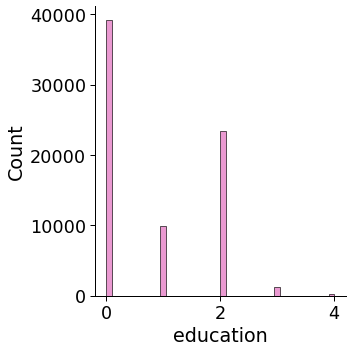

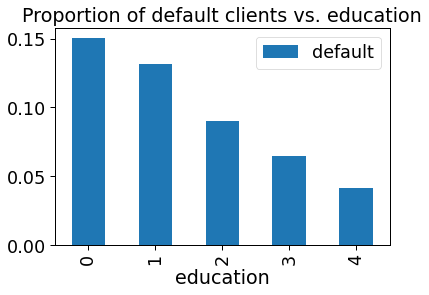

In [363]:
describe_column(train, 'education', 'cat')

### Любопытства ради глянем на зависимость уровня дохода от образования
### *Это надо показывать детям :-)*

<AxesSubplot:xlabel='education', ylabel='income'>

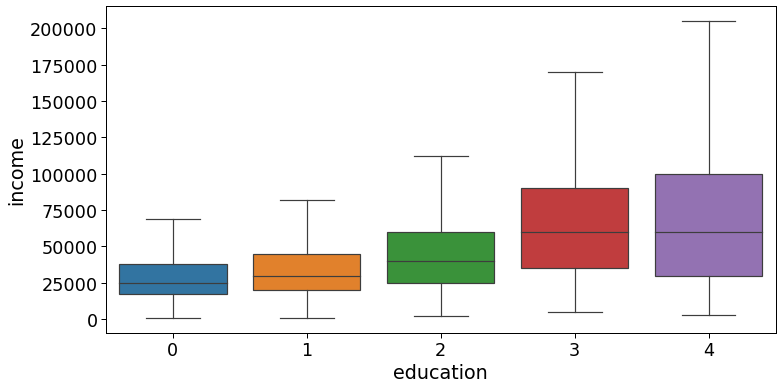

In [364]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="education", y="income", data=train, showfliers=False)

### Наблюдения о колонке 'education':

- ординальный признак - значений всего 5 и они упорядочены
- образованных клиентов уровня postgraduate и academic degree мало, суммарно около 2%
- больше всего среди обратившихся за кредитом наименее образованных - 53%
- интересно, почему бакалавры реже ходят за кредитами, чем магистры? Возможно заняты учёбой :-)
- налицо обратная зависимость между уровнем образования и вероятностью дефолта
- количество дефолтных падает с 15% среди наименее образованных до 4% среди "академиков"

## 1.8. 'sex' - пол, бинарный

Всего 41562 клиентов в категории 'F' - 56.3% от общего числа клиентов
Из них: 5039 (12.1%) дефолтных и 36523 (87.9%) недефолтных

Всего 32237 клиентов в категории 'M' - 43.7% от общего числа клиентов
Из них: 4333 (13.4%) дефолтных и 27904 (86.6%) недефолтных



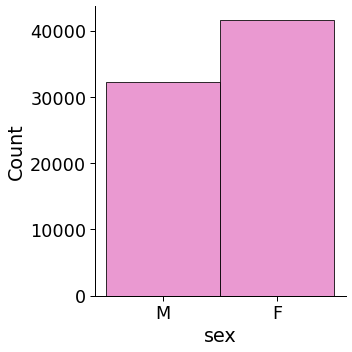

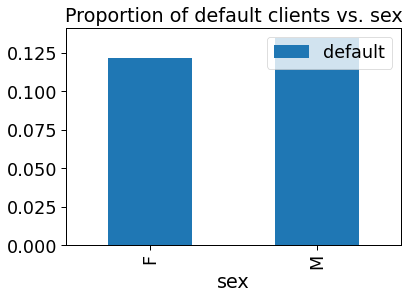

In [365]:
describe_column(train, 'sex', 'cat')

<AxesSubplot:xlabel='sex', ylabel='income'>

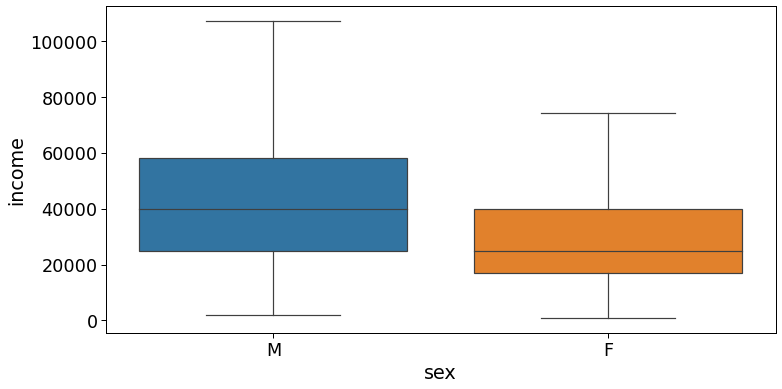

In [366]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="sex", y="income", data=train, showfliers=False)

<AxesSubplot:xlabel='sex', ylabel='score_bki'>

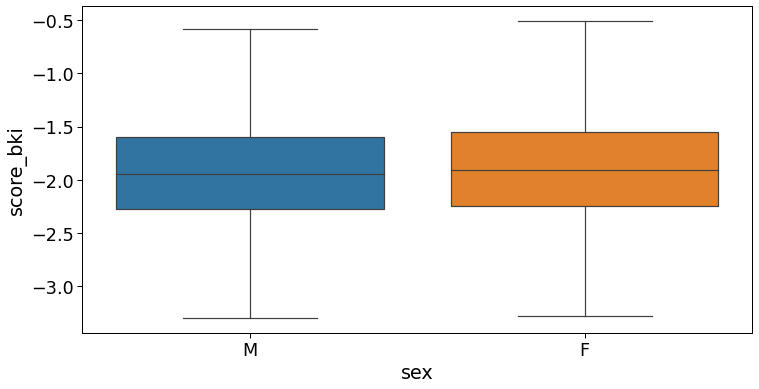

In [367]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="sex", y="score_bki", data=train, showfliers=False)

In [368]:
# sex_dict = {'F': 0, 'M': 1}
# train.sex = train.sex.replace(sex_dict)

### Наблюдения о колонке 'sex'

- бинарный признак - М и Ж
- женщины в среднем чуть чаще обращаются за кредитами - 56% против 44%
- уровень дефолтности различается незначительно - 12 и 13 %

## 1.9. 'car' - флаг наличия автомобиля , бинарный

Всего 49832 клиентов в категории 'N' - 67.5% от общего числа клиентов
Из них: 6825 (13.7%) дефолтных и 43007 (86.3%) недефолтных

Всего 23967 клиентов в категории 'Y' - 32.5% от общего числа клиентов
Из них: 2547 (10.6%) дефолтных и 21420 (89.4%) недефолтных



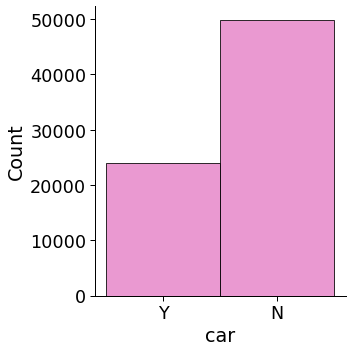

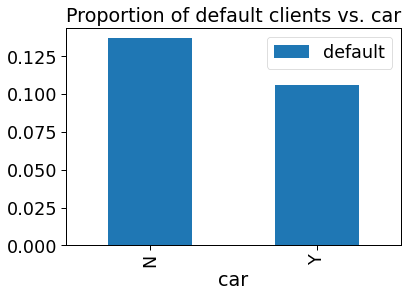

In [369]:
describe_column(train, 'car', 'cat')

### Наблюдения о колонке 'car'

- бинарный признак - есть авто или нет
- безлошадных 67.5% - видимо берут кредит на покупку авто :-)
- уровень дефолтности для клиентов без авто 13.7%, у клиентов с авто 10.6%

In [370]:
# # Перекодируем в 0 и 1
# car_dict = {'N': 0, 'Y': 1}
# train.car = train.car.replace(car_dict)

## 1.10. 'car_type' - флаг автомобиля иномарки, бинарный

Всего 59791 клиентов в категории 'N' - 81.0% от общего числа клиентов
Из них: 8147 (13.6%) дефолтных и 51644 (86.4%) недефолтных

Всего 14008 клиентов в категории 'Y' - 19.0% от общего числа клиентов
Из них: 1225 (8.7%) дефолтных и 12783 (91.3%) недефолтных



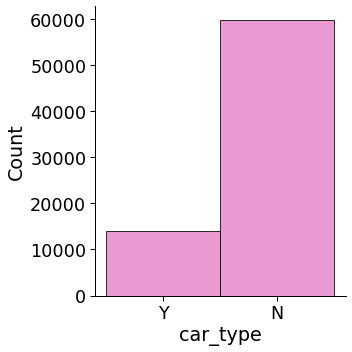

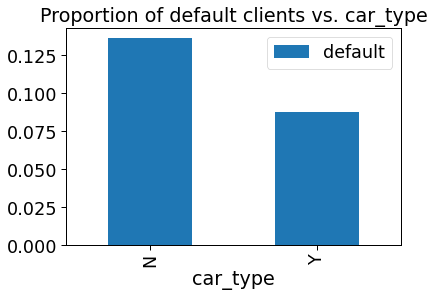

In [371]:
describe_column(train, 'car_type', 'cat')

In [372]:
# car_type_dict = {'N': 0, 'Y': 1}
# train.car_type = train.car_type.replace(car_type_dict)

### Наблюдения о колонке 'car_type'

- бинарный признак - иномарка или нет
- на иномарках всего 19% клиентов
- уровень дефолтности у "иномарочников" ниже - 8.7%, против 13.6% у адептов отечественного автопрома

## 1.11. 'good_work' - флаг наличия “хорошей” работы, бинарный

Всего 61630 клиентов в категории '0' - 83.5% от общего числа клиентов
Из них: 8222 (13.3%) дефолтных и 53408 (86.7%) недефолтных

Всего 12169 клиентов в категории '1' - 16.5% от общего числа клиентов
Из них: 1150 (9.5%) дефолтных и 11019 (90.5%) недефолтных



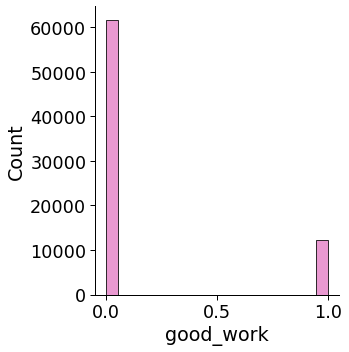

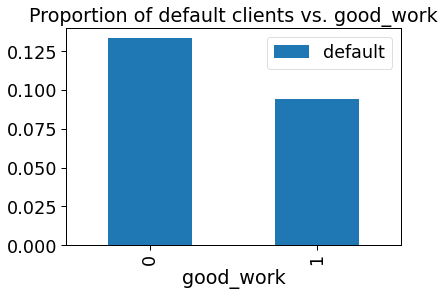

In [373]:
describe_column(train, 'good_work', 'cat')

### Наблюдения о колонке 'good_work':

- бинарный признак - работа либо хорошая, либо плохая
- с хорошей работой всего 16%- ну ещё бы...
- уровень дефолтности у обладателей "хорошей работы" ниже - 9.5%, против 13.3% у остальных

## 1.12. 'home_address' - категоризатор домашнего адреса, категориальный

Всего 32585 клиентов в категории '1' - 44.2% от общего числа клиентов
Из них: 3027 (9.3%) дефолтных и 29558 (90.7%) недефолтных

Всего 39956 клиентов в категории '2' - 54.1% от общего числа клиентов
Из них: 6199 (15.5%) дефолтных и 33757 (84.5%) недефолтных

Всего 1258 клиентов в категории '3' - 1.7% от общего числа клиентов
Из них: 146 (11.6%) дефолтных и 1112 (88.4%) недефолтных



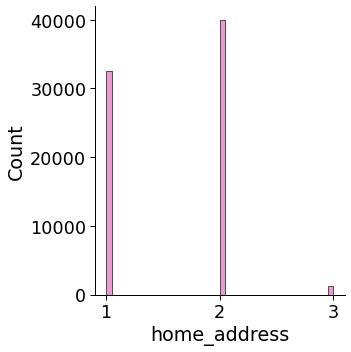

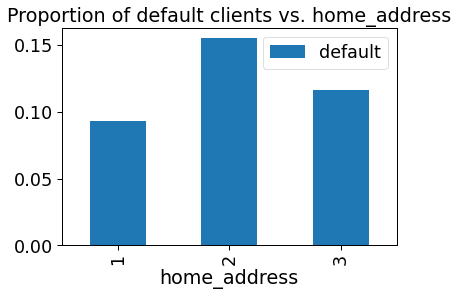

In [374]:
describe_column(train, 'home_address', 'cat')

### Наблюдения о колонке 'home_address':

- категориальный признак с тремя вариантами [1, 2, 3] и непонятным физическим смыслом
- Клиентов в категории '1' - 44.2%, '2' - 54.1% и '3' - 1.7% от общего числа клиентов
- Дефолтных соответсвтенно 9.3%, 15.5% и 11.6%

## 1.13. 'work_address' - категоризатор рабочего адреса, категориальный

Всего 8334 клиентов в категории '1' - 11.3% от общего числа клиентов
Из них: 618 (7.4%) дефолтных и 7716 (92.6%) недефолтных

Всего 20506 клиентов в категории '2' - 27.8% от общего числа клиентов
Из них: 2102 (10.3%) дефолтных и 18404 (89.7%) недефолтных

Всего 44959 клиентов в категории '3' - 60.9% от общего числа клиентов
Из них: 6652 (14.8%) дефолтных и 38307 (85.2%) недефолтных



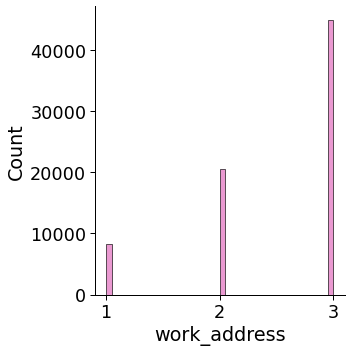

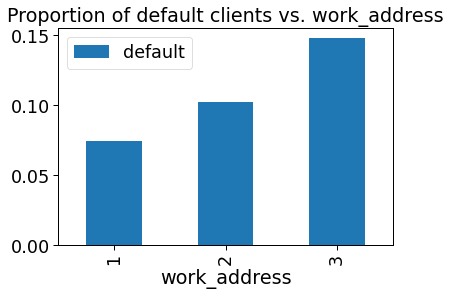

In [375]:
describe_column(train, 'work_address', 'cat')

### Наблюдения о колонке 'work_address':

- категориальный признак с тремя вариантами [1, 2, 3] и непонятным физическим смыслом
- Клиентов в категории '1' - 11.3%, '2' - 27.8% и '3' - 60.9% от общего числа клиентов
- Дефолтных соответсвтенно 7.4%, 10.3% и 14.8% - то есть налицо положительная связь между 'work_address' и дефолтностью

## 1.14. 'sna' - связь заемщика с клиентами банка, категориальный

Всего 47301 клиентов в категории '1' - 64.1% от общего числа клиентов
Из них: 4645 (9.8%) дефолтных и 42656 (90.2%) недефолтных

Всего 10626 клиентов в категории '2' - 14.4% от общего числа клиентов
Из них: 1592 (15.0%) дефолтных и 9034 (85.0%) недефолтных

Всего 4123 клиентов в категории '3' - 5.6% от общего числа клиентов
Из них: 650 (15.8%) дефолтных и 3473 (84.2%) недефолтных

Всего 11749 клиентов в категории '4' - 15.9% от общего числа клиентов
Из них: 2485 (21.2%) дефолтных и 9264 (78.8%) недефолтных



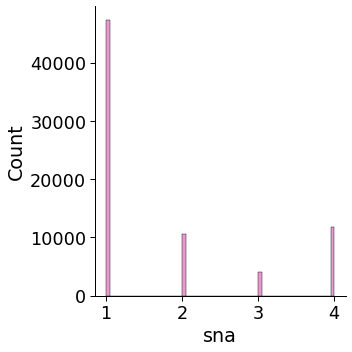

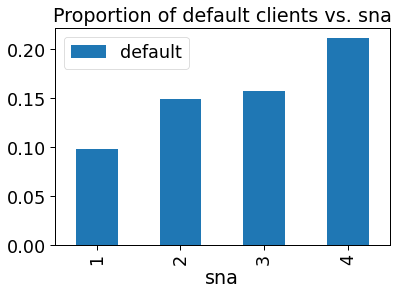

In [376]:
describe_column(train, 'sna', 'cat')

### Наблюдения о колонке 'sna':

- Категориальный признак с четырьмя вариантами [1, 2, 3, 4] и непонятным физическим смыслом;
- Больше клиентов в категории '1' - 64.1%;
- Пропорция дефолтных тем выше, чем выше категория 'sna' от 9.8% для категории '1' до 21.2% для категории '4'.

## 1.15. 'first_time' - давность наличия информации о заемщике, категориальный

Всего 12239 клиентов в категории '1' - 16.6% от общего числа клиентов
Из них: 2278 (18.6%) дефолтных и 9961 (81.4%) недефолтных

Всего 11568 клиентов в категории '2' - 15.7% от общего числа клиентов
Из них: 1798 (15.5%) дефолтных и 9770 (84.5%) недефолтных

Всего 31255 клиентов в категории '3' - 42.4% от общего числа клиентов
Из них: 3759 (12.0%) дефолтных и 27496 (88.0%) недефолтных

Всего 18737 клиентов в категории '4' - 25.4% от общего числа клиентов
Из них: 1537 (8.2%) дефолтных и 17200 (91.8%) недефолтных



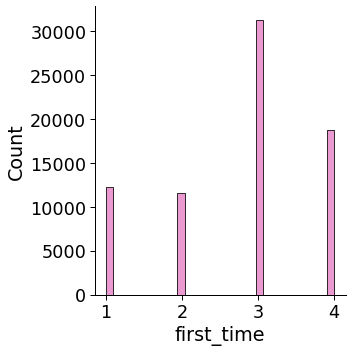

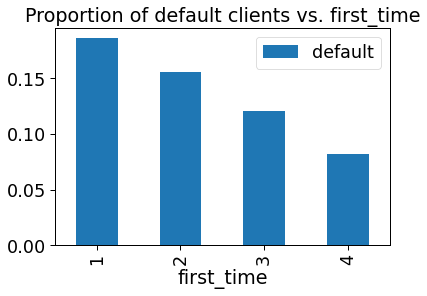

In [377]:
describe_column(train, 'first_time', 'cat')

### Наблюдения о колонке 'first_time':

- Категориальный признак с четырьмя вариантами [1, 2, 3, 4], предположительно чем больше показатель, тем дольше у банка имеется в наличии информация о заемщике;
- Больше клиентов в категории '3' - 42.4%;
- Пропорция дефолтных тем ниже, чем выше категория 'first_time' от 18.6% для категории '1' до 8.2% для категории '4'.

## 1.16. 'foreign_passport' - наличие загранпаспорта, бинарный

Всего 62733 клиентов в категории 'N' - 85.0% от общего числа клиентов
Из них: 8552 (13.6%) дефолтных и 54181 (86.4%) недефолтных

Всего 11066 клиентов в категории 'Y' - 15.0% от общего числа клиентов
Из них: 820 (7.4%) дефолтных и 10246 (92.6%) недефолтных



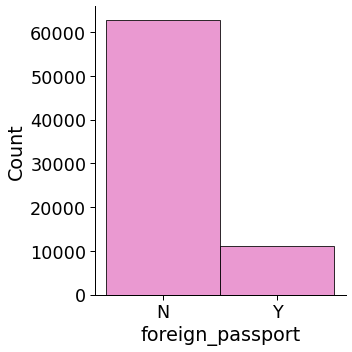

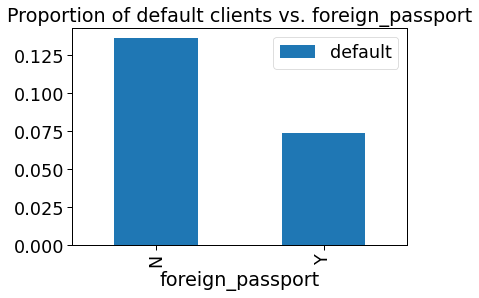

In [378]:
describe_column(train, 'foreign_passport', 'cat')

In [379]:
train.foreign_passport = train.foreign_passport.replace({'N': 0, 'Y': 1})

### Наблюдения о колонке 'foreign_passport':

- бинарный признак - есть паспорт или нет
- безпаспортных 85.0%
- уровень дефолтности для клиентов без паспорта существенно выше - 13.6%, у клиентов с паспортом лишь 7.4%

## 1.17. 'app_date - дата подачи заявки

In [380]:
# # переводим дату в datetime
# train.app_date = pd.to_datetime(train.app_date)

# train
# # Выводим период наблюдений:
# display(train.app_date.max())
# display(train.app_date.min())

In [381]:
# # Можно не обращать внимания на год, он везде будет 2014-й
# train['app_day'] = train.app_date.dt.day
# train['app_month'] = train.app_date.dt.month
# train["app_weekday"] = train.app_date.dt.weekday

# # Количество дней, прошедших с начала наблюдений:
# train['days'] = (train.app_date - train.app_date.min()).dt.days

In [382]:
# describe_column(train, 'app_day', 'cat')

In [383]:
# describe_column(train, 'app_month', 'cat')

In [384]:
# describe_column(train, 'app_weekday', 'cat')

In [385]:
# plt.figure(figsize=(10,5))
# sns.heatmap(train.iloc[:,19:].corr(), annot=True)

In [386]:
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,0,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,0,0
1,63161,12MAR2014,0,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,0,0
2,25887,01FEB2014,0,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,1,0
3,16222,23JAN2014,0,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,0,0
4,101655,18APR2014,2,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,1,0


In [387]:
train.drop(["app_date"], axis=1, inplace=True)

train.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,0,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,0,0
1,63161,0,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,0,0
2,25887,0,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,1,0
3,16222,0,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,0,0
4,101655,2,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,1,0


### Наблюдения о колонке 'app_date':

- для наивной модели пока просто удалим, а дальше поглядим.

# 2. Строим модели

## 2.1. Наивная модель

Итак, напишем функцию предобработки данных для наивной модели, предобработка минимальная:
 - удалить пропуски в колонке 'education'
 - перекодировать колонку 'education' вручную
 - перекодируем все бинарные колонки
 - и всё - это самое днище предобработки для наивной модели

In [388]:
def preprocessing_model_1(df):
    # удаляем колонку 'app_date'
    df.drop('app_date', axis=1, inplace=True)
    
    # удаляем пропуски в колонке 'education'
    df.education = df.education.fillna(df.education.mode()[0])
    # перекодируем 'education' вручную - ординальный признак
    df.education = df.education.replace({'SCH': 0, # school - школьное образование
                                         'UGR': 1, # undergraduate - бакалавр
                                         'GRD': 2, # graduate - магистр
                                         'PGR': 3, # postgraduate - профессиональная специализация
                                         'ACD': 4  # academic degree
                                        })
    # категориальные признаки 
    cats = ['education', 'region_rating', 'home_address', 
            'work_address', 'sna', 'first_time']
  
    # бинарные переменные
    bins = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
        
    # все бинарные колонки перекодируем
    le = LabelEncoder()
    for column in bins:
        le.fit(df[column])
        df[column] = le.transform(df[column])
    
    # числовые переменные
    nums = ['age', 'decline_app_cnt', 'score_bki', 'income', 'bki_request_cnt']
    
    return

In [389]:
train = pd.read_csv(path +'/train.csv')

preprocessing_model_1(train)

X = train.drop('default', axis = 1) # удаляем целевую переменную 'default'
y = train.drop(train.iloc[:, :-1], axis = 1) # выделяем целевую переменную

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)

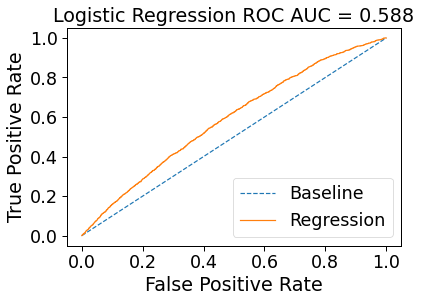

In [390]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [391]:
# Оценка качества:
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

# Построим матрицу ошибок
confusion_matrix(y_test, y_pred)

accuracy_score: 0.8722
f1_score: 0.0
recall_score: 0.0
MSE: 0.1278


array([[12873,     0],
       [ 1887,     0]])

<AxesSubplot:>

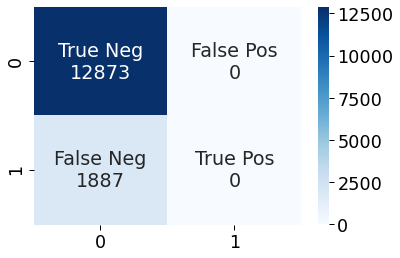

In [392]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')

### Выводы относительно наивной модели:
- Предсказывает плохо;
- ROC AUC = 0.588, то есть чуть лучше, чем бросать монетку;
- Confusion matrix:
 - _TN - спрогнозировали, что дефолта нет и его правда нет - 12873;_
 - _FN - спрогнозировали, что дефолта нет, а он есть - 1887;_
 - _TP - спрогнозировали, что дефолт есть, и он правда есть - 0;_
 - _FP - спрогнозировали, что дефолт есть, а его нет - 0;_
- То есть модель добрейшей души - про всех говорит, что дефолта не будет;
- Зато есть куда расти.

### Теперь сделаем submission с полученной моделью

In [393]:
# Обучаем модель на всём сете train
model = LogisticRegression()
model.fit(X, y)

test = pd.read_csv(path +'/test.csv')

preprocessing_model_1(test)

y_submission = model.predict_proba(test)
y_submission = y_submission[:,1]

test['default'] = y_submission

test['default'] = y_submission

submission = test[['client_id','default']]

submission.to_csv(path + '/submission_r01_naive.csv', index=False)

## 2.2. Модель №2 - с улучшенной предобработкой

### План такой:
- Не удаляем дату, а вытаскиваем из нее число, месяц и год в отдельные колонки;
- Перекодируем все категориальные признаки;
- Числовые признаки логарифмируем (кроме 'score_bki', который < 0);
- Смотрим на результат и думаем дальше.

In [394]:
def preprocessing_model_2(df):
    # переводим дату в datetime
    df.app_date = pd.to_datetime(df.app_date)
    
    # На этапе EDA видели, что год везде 2014, поэтому год исключаем
    df['app_day'] = df.app_date.dt.day
    df['app_month'] = df.app_date.dt.month
    df['app_weekday'] = df.app_date.dt.weekday

    df.drop('app_date', axis=1, inplace=True)
    
    # удаляем пропуски в колонке 'education'
    df.education = df.education.fillna(df.education.mode()[0])
    # перекодируем 'education' вручную - ординальный признак
    df.education = df.education.replace({'SCH': 0, # school - школьное образование
                                         'UGR': 1, # undergraduate - бакалавр
                                         'GRD': 2, # graduate - магистр
                                         'PGR': 3, # postgraduate - профессиональная специализация
                                         'ACD': 4  # academic degree
                                        })
    
    # перекодируем 'region_rating' вручную - ординальный признак
    df.region_rating = df.region_rating.replace({20: 0, 30: 1, 40: 2, 50: 3, 
                                                 60: 4, 70: 5, 80: 6
                                                })
    
    cats = ['home_address', 'work_address', 'sna', 'first_time'] # категориальные переменные
    # Получаем массив в котором кол-во колонок равно сумме различных категорий по каждому признаку
    # Единичка стоит в колонках, соответствующих каждому признаку
    X_cat = OneHotEncoder(sparse = False).fit_transform(df[cats].values)
        
  
    bins = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport'] # бинарные переменные
        
    # все бинарные колонки перекодируем прямо в датайрейме df
    le = LabelEncoder()
    for column in bins:
        le.fit(df[column])
        df[column] = le.transform(df[column])
    
    # числовые переменные - добавили производные даты
    # также добавили перекодированные ординальные переменные:
    # 'education' и 'region_rating'
    nums = ['age', 'decline_app_cnt', 'score_bki', 'income', 'bki_request_cnt', 
            'app_day', 'app_month', 'app_weekday', 'education', 'region_rating']
    
    # логарифмирование кроме колонки 'score_bki', значения в которой < 0
    for column in nums:
        if column != 'score_bki': 
            df[column] = df[column].apply(np.log1p)
    X_num = df[nums].values
    
    # cтандартизация числовых переменных - пробовал её вместо
    # логарифмирования, но модель лучше не становится
    # X_num = StandardScaler().fit_transform(train[nums].values)
    
    return df[bins].values, X_cat, X_num

In [395]:
train = pd.read_csv(path +'/train.csv')

X_bins, X_cats, X_nums = preprocessing_model_2(train)

X = np.hstack([X_bins, X_cats, X_nums])
y = train['default'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)

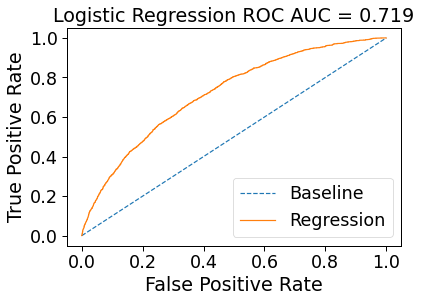

In [396]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [397]:
# Оценка качества:
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

# Построим матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
print(f"Расшифровка Матрицы Ошибок:")
print(f"TP, истинно положительные (дефолт классифицирован как дефолт): {cm[1,1]}")
print(f"TN, истинно отрицательные (не-дефолт классифицирован как не-дефолт): {cm[0,0]}")
print(f"FN, ложно отрицательные (дефолт классифицирован как не-дефолт): {cm[1,0]} - Bad, model, bad!!!")
print(f"FN, ложно положительные (не-дефолт классифицирован как дефолт): {cm[0,1]}")

accuracy_score: 0.8724
f1_score: 0.0646
recall_score: 0.0344
MSE: 0.1276
Расшифровка Матрицы Ошибок:
TP, истинно положительные (дефолт классифицирован как дефолт): 65
TN, истинно отрицательные (не-дефолт классифицирован как не-дефолт): 12812
FN, ложно отрицательные (дефолт классифицирован как не-дефолт): 1822 - Bad, model, bad!!!
FN, ложно положительные (не-дефолт классифицирован как дефолт): 61


<AxesSubplot:>

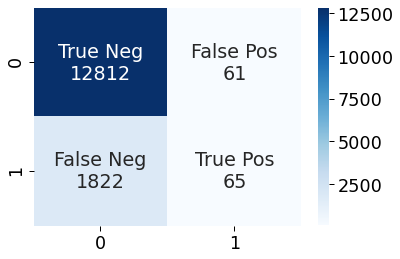

In [398]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')

### Выводы относительно модели №2  - с улучшенной предобработкой:
- Предсказывает заметно лучше наивной модели - ROC AUC = 0.719;
- Confusion matrix:
 - _TN - спрогнозировали, что дефолта нет и его правда нет - 12812;_
 - _FN - спрогнозировали, что дефолта нет, а он есть - 1822;_
 - _TP - спрогнозировали, что дефолт есть, и он правда есть - 65;_
 - _FP - спрогнозировали, что дефолт есть, а его нет - 61;_
- Думаем дальше.

### Теперь сделаем submission с полученной моделью №2

In [399]:
# Обучаем модель на всём сете train
model = LogisticRegression()
model.fit(X, y)

test = pd.read_csv(path +'/test.csv')

test_bins, test_cats, test_nums = preprocessing_model_2(test)

test_submission = np.hstack([test_bins, test_cats, test_nums])
y_submission = model.predict_proba(test_submission)

y_submission = y_submission[:,1]

test['default'] = y_submission

submission = test[['client_id','default']]

submission.to_csv(path + '/submission_r02.csv', index=False)

## 2.3. Модель №3 с улучшенной предобработкой и подбором признаков

### План такой:
- Предобработку оставляем, как в предыдущем варианте;
- Cмотрим на корреляцию между числовыми признаками и удаляем наиболее взаимосвязанные. Оцениваем следующим образом:
 - _от 0 до 0,3 очень слабая_
 - _от 0,3 до 0,5 слабая_
 - _от 0, 5 до 0,7 средняя_
 - _от 0,7 до 0,9 высокая_
 - _от 0,9 до 1	очень высокая_
- Смотрим на значимость столбцов, оставляем наиболее значимые столбцы, остальные удаляем;
- Смотрим на результат и думаем дальше.

### Смотрим на корреляцию числовых признаков:

- Пробовали удалить 'education' и 'region_rating', т.к. они хоть и слабо, но коррелируют с 'income'
- Пробовали удалить 'decline_app_cnt' и 'bki_request_cnt', т.к. они хоть и слабо, но коррелируют с 'score_bki'
- ROC AUC падает с 0.719 до 0.697, поэтому "вертаем всё взад"
    

### Смотрим на значимость числовых переменных:

- из 10 числовых переменных оставим 5 наиболее значимых:
 - _['decline_app_cnt', 'score_bki', 'bki_request_cnt', 'education', 'region_rating']_
- ROC AUC падает с 0.719 до 0.717, поэтому всё отменяем

### Признаки 'education' и 'region_rating' тупо отправили в список категориальных
### ROC AUC подрос на 0.01 и поднялись на 40 позиций в Kaggle (!)

### Смотрим на корреляцию бинарных признаков:

- Сильно коррелируют 'car' и 'car_type';
- Попробуем сделать 'car' категориальным: NN - нет авто, YN - российский автопром, YY - иномарка
- ROC AUC не изменилось с 0.721
    

In [400]:
def preprocessing_model_3(df):
    # переводим дату в datetime
    df.app_date = pd.to_datetime(df.app_date)
    
    # На этапе EDA видели, что год везде 2014, поэтому год исключаем
    df['app_day'] = df.app_date.dt.day
    df['app_month'] = df.app_date.dt.month
    df['app_weekday'] = df.app_date.dt.weekday

    df.drop('app_date', axis=1, inplace=True)
    
    # удаляем пропуски в колонке 'education'
    df.education = df.education.fillna(df.education.mode()[0])
    
    # делаем 'car' категориальным: NN - нет авто, YN - российский автопром, YY - иномарка
    df.car = df.car + df.car_type
    
    # категориальные переменные
    cats = ['home_address', 'work_address', 'sna', 'first_time', 
            'education', 'region_rating', 'car']
    X_cat = OneHotEncoder(sparse = False).fit_transform(df[cats].values)
        
    # бинарные переменные
    bins = ['sex', 'good_work', 'foreign_passport']

    # все бинарные колонки перекодируем прямо в датайрейме df
    le = LabelEncoder()
    for column in bins:
        le.fit(df[column])
        df[column] = le.transform(df[column])
        
    # Построим матрицу корреляций для бинарных признаков:
#     plt.figure(figsize=(10,5))
#     sns.heatmap(df[bins + ['default']].corr(), annot=True)
    
    # числовые переменные - добавили производные даты
    # также добавили перекодированные ординальные переменные:
    # 'education' и 'region_rating'
    
    nums = ['age', 'decline_app_cnt', 'score_bki', 'income', 'bki_request_cnt', 
            'app_day', 'app_month', 'app_weekday']
    
#     # смотрим на корреляцию числовых признаков    
#     sns.heatmap(df[nums].corr().abs(), vmin=0, vmax=1)
        
#     # смотрим на значимость числовых переменных
#     imp_num = pd.Series(f_classif(df[nums], df['default'])[0], index = nums)
#     imp_num.sort_values(inplace = True)
#     imp_num.plot(kind = 'barh')
#     # из 10 числовых переменных оставим 5 более значимых:
#     nums = ['decline_app_cnt', 'score_bki', 'bki_request_cnt', 
#             'education', 'region_rating']

    # логарифмирование кроме колонки 'score_bki', значения в которой < 0
    for column in nums:
        if column != 'score_bki': 
            df[column] = df[column].apply(np.log1p)
    X_num = df[nums].values
    
    # cтандартизация числовых переменных - пробовал её вместо
    # логарифмирования, но модель лучше не становится
    # X_num = StandardScaler().fit_transform(train[nums].values)
    
    return df[bins].values, X_cat, X_num

In [401]:
train = pd.read_csv(path +'/train.csv')

X_bins, X_cats, X_nums = preprocessing_model_3(train)

X = np.hstack([X_bins, X_cats, X_nums])
y = train['default'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)

0.72114


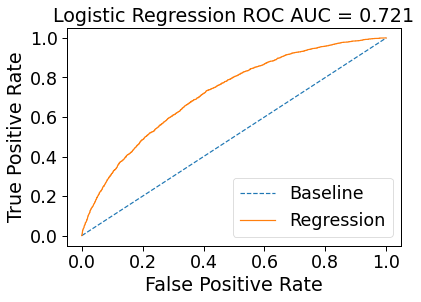

In [402]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

print(round(roc_auc, 5))

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [403]:
# Оценка качества:
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

# Построим матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
print(f"Расшифровка Матрицы Ошибок:")
print(f"TP, истинно положительные (дефолт классифицирован как дефолт): {cm[1,1]}")
print(f"TN, истинно отрицательные (не-дефолт классифицирован как не-дефолт): {cm[0,0]}")
print(f"FN, ложно отрицательные (дефолт классифицирован как не-дефолт): {cm[1,0]} - Bad, model, bad!!!")
print(f"FN, ложно положительные (не-дефолт классифицирован как дефолт): {cm[0,1]}")

accuracy_score: 0.8727
f1_score: 0.0628
recall_score: 0.0334
MSE: 0.1273
Расшифровка Матрицы Ошибок:
TP, истинно положительные (дефолт классифицирован как дефолт): 63
TN, истинно отрицательные (не-дефолт классифицирован как не-дефолт): 12818
FN, ложно отрицательные (дефолт классифицирован как не-дефолт): 1824 - Bad, model, bad!!!
FN, ложно положительные (не-дефолт классифицирован как дефолт): 55


<AxesSubplot:>

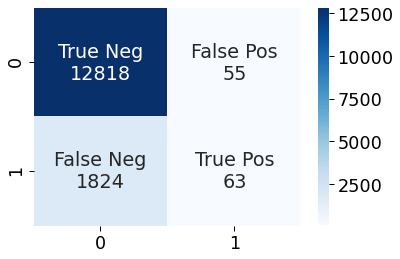

In [404]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')

### Выводы относительно модели №3 - с улучшенной предобработкой и подбором признаков:
- Предсказывает чуть лучше модели №2 - ROC AUC = 0.72114;
- Confusion matrix практически не изменилась:
 - _TN - спрогнозировали, что дефолта нет и его правда нет - 12818;_
 - _FN - спрогнозировали, что дефолта нет, а он есть - 1824;_
 - _TP - спрогнозировали, что дефолт есть, и он правда есть - 63;_
 - _FP - спрогнозировали, что дефолт есть, а его нет - 55;_
- Думаем дальше.

### Теперь сделаем submission с полученной моделью №3

In [405]:
# Обучаем модель на всём сете train
train = pd.read_csv(path +'/train.csv')

X_bins, X_cats, X_nums = preprocessing_model_3(train)

X = np.hstack([X_bins, X_cats, X_nums])
y = train['default'].values

model = LogisticRegression()
model.fit(X, y)

test = pd.read_csv(path +'/test.csv')

test_bins, test_cats, test_nums = preprocessing_model_3(test)

test_submission = np.hstack([test_bins, test_cats, test_nums])
y_submission = model.predict_proba(test_submission)

y_submission = y_submission[:,1]

test['default'] = y_submission

submission = test[['client_id','default']]

submission.to_csv(path + '/submission_r03.csv', index=False)

## 2.4. Модель №4 с дальнейшими улучшениями предобработки и подбором признаков

### План такой:
- Предобработку оставляем, как в предыдущем варианте;
- Категоризируем возраст;
- Создаем и пробуем полиномиальные признаки из выбранных числовых;
- Категоризируем 'decline_app_cnt' и 'bki_request_cnt';
- Из двух столбцов ['work_address', 'home_address'] делаем один путем усечения ненужной информации методом главных компонент - Principal component analysis (PCA);
- пробуем стандартизацию числовых переменных;
- Смотрим на результат и думаем дальше.

In [406]:
# Категоризация возраста согласно древним китайцам

def age_to_cat(age):
    if age < 25:
        return 'Молодость'
    if age < 30:
        return 'Пора вступления в брак'
    if age < 40:
        return 'Возраст выполнения общественных '
    if age < 50:
        return 'Познание собственных заблуждений'
    if age < 60:
        return 'Последний период творческой жизни'
    if age < 70:
        return 'Желанный возраст'
    else:
        return 'Старость'

def preprocessing_model_4(df):
    # переводим дату в datetime
    df.app_date = pd.to_datetime(df.app_date)
    
    # на этапе EDA видели, что год везде 2014, поэтому год не рассматриваем
    df['app_day'] = df.app_date.dt.day
    df['app_month'] = df.app_date.dt.month
    df['app_weekday'] = df.app_date.dt.weekday
    
    # количество дней, прошедших с начала наблюдений
    df['days'] = (df.app_date - df.app_date.min()).dt.days
    
    # выяснили раньше - app_month сильно коррелирует с days, поэтому исключаем
    # уберем столбец app_date, он нам больше не нужен
    df.drop('app_month', axis=1, inplace=True)
    df.drop('app_date', axis=1, inplace=True)
    
    # заменяем пропуски в колонке 'education' на моду
    df.education = df.education.fillna(df.education.mode()[0])
    
    # делаем 'car' категориальным: NN - нет авто, YN - российский автопром, YY - иномарка
    df.car = df.car + df.car_type
    
    # для уменьшения количества выбросов переведем в категориальный признак
    # 'decline_app_cnt' и 'bki_request_cnt' по принципу "ноль-один-два-три-много"
    df.decline_app_cnt = df.decline_app_cnt.apply(lambda x: (x if x < 10 else 10))
    df.bki_request_cnt = df.bki_request_cnt.apply(lambda x: (x if x < 10 else 10))
    
    # категоризируем возраст
    df.age = df.age.apply(age_to_cat)
    
    # Выберем из датасета нужные колонки:
    data = df[['work_address', 'home_address']].values

    # Создадим Scaler instance:
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # Из двух столбцов сделаем один путем усечения ненужной информации.
    pca = PCA(n_components=1)
    pca.fit(scaled_data)
    pca_data = pca.transform(scaled_data)
    df['address'] = pca_data
    
    # категориальные переменные кодируем при помощи OneHotEncoder()
    cats = ['address', 'sna', 'first_time', 'education', 
            'region_rating', 'car', 'decline_app_cnt', 'bki_request_cnt', 'age']
    X_cat = OneHotEncoder(sparse = False).fit_transform(df[cats].values)
        
    # бинарные переменные
    bins = ['sex', 'good_work', 'foreign_passport']

    # все бинарные колонки перекодируем прямо в датайрейме df
    le = LabelEncoder()
    for column in bins:
        le.fit(df[column])
        df[column] = le.transform(df[column])
    
    nums = ['score_bki', 'income', 'app_weekday', 'days']
   
    # логарифмирование выбранные колонки и помним, что 'score_bki' < 0
    for column in nums:
        if column in ['income']: 
            df[column] = df[column].apply(np.log1p)
    
    # cтандартизация числовых переменных - пробовал её вместо
    # логарифмирования, но модель лучше не становится
    X_num = StandardScaler().fit_transform(df[nums].values)
    
    # добавим новые полиномиальные признаки из математических
    # комбинаций числовых признаков ['score_bki', 'income', 'days']
    pf_columns = ['score_bki', 'income', 'days']
    pf = PolynomialFeatures(2, include_bias=False)
    poly_data = pf.fit_transform(df[pf_columns])[:, len(pf_columns):]
    poly_cols = pf.get_feature_names()[len(pf_columns):]
    poly_df = pd.DataFrame(poly_data, columns=poly_cols)
    df = df.join(poly_df, how='left')
#     X_num = np.hstack([X_num, poly_df.values])
    
    return df[bins].values, X_cat, X_num

In [407]:
# обрабатываем и разбиваем

train = pd.read_csv(path +'/train.csv')

X_bins, X_cats, X_nums = preprocessing_model_4(train)

X = np.hstack([X_bins, X_cats, X_nums])
y = train['default'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)

ROC AUC: 0.721885



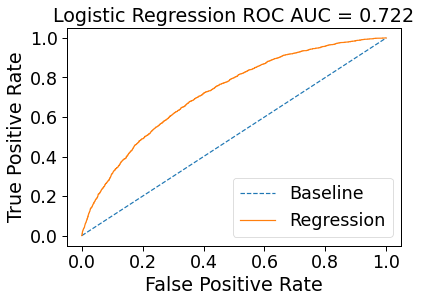

In [408]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

print(f"ROC AUC: {round(roc_auc, 6)}\n")

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [409]:
# Оценка качества:
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}\n'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"Расшифровка Матрицы Ошибок:")
print(f"TP, истинно положительные (дефолт классифицирован как дефолт): {cm[1,1]}")
print(f"TN, истинно отрицательные (не-дефолт классифицирован как не-дефолт): {cm[0,0]}")
print(f"FN, ложно отрицательные (дефолт классифицирован как не-дефолт): {cm[1,0]} - Bad, model, bad!!!")
print(f"FP, ложно положительные (не-дефолт классифицирован как дефолт): {cm[0,1]}")

accuracy_score: 0.8721
f1_score: 0.0522
recall_score: 0.0276
MSE: 0.1279

[[12820    53]
 [ 1835    52]]
Расшифровка Матрицы Ошибок:
TP, истинно положительные (дефолт классифицирован как дефолт): 52
TN, истинно отрицательные (не-дефолт классифицирован как не-дефолт): 12820
FN, ложно отрицательные (дефолт классифицирован как не-дефолт): 1835 - Bad, model, bad!!!
FP, ложно положительные (не-дефолт классифицирован как дефолт): 53


<AxesSubplot:>

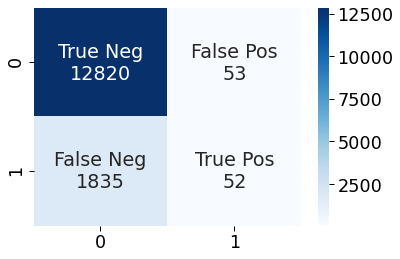

In [410]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')

### Выводы относительно модели №4 :
- Предсказывает аналогично модели №3 - ROC AUC = 0.721885;
- Confusion matrix меняется слабо:
 - _TN - спрогнозировали, что дефолта нет и его правда нет - 12820;_
 - _FN - спрогнозировали, что дефолта нет, а он есть - 1835;_
 - _TP - спрогнозировали, что дефолт есть, и он правда есть - 52;_
 - _FP - спрогнозировали, что дефолт есть, а его нет - 53;_
- Думаем дальше.

### Теперь сделаем submission с полученной моделью №4

In [411]:
# Обучаем модель на всём сете train
train = pd.read_csv(path +'/train.csv')

X_bins, X_cats, X_nums = preprocessing_model_4(train)

X = np.hstack([X_bins, X_cats, X_nums])
y = train['default'].values

model = LogisticRegression()
model.fit(X, y)

test = pd.read_csv(path +'/test.csv')

# Применяем все наши манипуляции к test
test_bins, test_cats, test_nums = preprocessing_model_4(test)

test_submission = np.hstack([test_bins, test_cats, test_nums])
y_submission = model.predict_proba(test_submission)

y_submission = y_submission[:,1]

test['default'] = y_submission

submission = test[['client_id','default']]

submission.to_csv(path + '/submission_r04.csv', index=False)

## 2.5. Игры разума с параметрами

### Берём вариант подготовки данных №4 и перебираем возможные (не все) гиперпараметры модели LogisticRegression()  

### На Slack видел следующий вариант побора гиперпараметров, но решил сделать руками:

In [413]:
# model = LogisticRegression(random_state=42)

# param_grid = [
#     {'penalty': ['l1'], 
#      'solver': ['liblinear', 'lbfgs'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#     {'penalty': ['l2'], 
#      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#     {'penalty': ['none'], 
#      'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
# ]
# gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
# gridsearch.fit(X_train, y_train)
# model = gridsearch.best_estimator_
# ## печатаем параметры
# best_parameters = model.get_params()

In [418]:
# обрабатываем и разбиваем

train = pd.read_csv(path +'/train.csv')

X_bins, X_cats, X_nums = preprocessing_model_4(train)

X = np.hstack([X_bins, X_cats, X_nums])
y = train['default'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)

### Перебор параметров руками, заодно выясняем, что не все параметры совместимы между собой

In [ ]:
penalty_list = ['l1', 'l2', 'none']
C_list = [1, 2, 5, 7, 10, 50, 100]
solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter_list = [100, 250, 500, 1000]

count = 1
total_counts = len(penalty_list) * len(C_list) * len(solver_list) * len(max_iter_list)

roc_auc_max = 0
roc_auc_min = 1

best_parameters = []

for p in penalty_list:
    for c in C_list:
        for s in solver_list:
            for m in max_iter_list:
                print(f"{count} из {total_counts} ", end = "")
                print(f"({round(count/total_counts*100, 2)}%) ", end = "")
                print(f"- [\'{p}\', ", end = "")
                print(f"{c}, " , end = "")
                print(f"\'{s}\', ", end = "")
                print(f"\'{m}\']", end = "")
                count += 1
                
                # 'newton-cg', 'lbfgs', 'sag', 'saga' handle L2 or no penalty
                if s in ['newton-cg', 'lbfgs', 'sag', 'saga']:
                    if p == 'l1':
                        print(f" - solver \'{s}\', penalty={p} => пропускаем\n")
                        continue
                
                # penalty='none' is not supported for the liblinear solver
                if s == 'liblinear' and p == 'none':
                    print(f" - solver \'{s}\', penalty={p} => пропускаем\n")
                    continue
                
                
                # пробовал моделировать с class_weight='balanced', модель ухудшается
                model = LogisticRegression(penalty = p, C = c, solver = s, max_iter = m)
                                
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                probs = model.predict_proba(X_test)
                probs = probs[:,1]

                fpr, tpr, threshold = roc_curve(y_test, probs)
                roc_auc = roc_auc_score(y_test, probs)

                if roc_auc_max < roc_auc:
                    roc_auc_max = roc_auc
                    best_parameters.clear()
                    best_parameters.append(p)
                    best_parameters.append(c)
                    best_parameters.append(s)
                    best_parameters.append(m)                 
                
                if roc_auc_min > roc_auc:
                    roc_auc_min = roc_auc
                
                print(f" - ROC AUC = {round(roc_auc, 6)}\n")

print(f"roc_auc_max = {round(roc_auc_max, 6)} при {best_parameters},")
print(f"roc_auc_min = {round(roc_auc_min, 6)}")

1 из 420 (0.24%) - ['l1', 1, 'newton-cg', '100'] - solver 'newton-cg', penalty=l1 => пропускаем

2 из 420 (0.48%) - ['l1', 1, 'newton-cg', '250'] - solver 'newton-cg', penalty=l1 => пропускаем

3 из 420 (0.71%) - ['l1', 1, 'newton-cg', '500'] - solver 'newton-cg', penalty=l1 => пропускаем

4 из 420 (0.95%) - ['l1', 1, 'newton-cg', '1000'] - solver 'newton-cg', penalty=l1 => пропускаем

5 из 420 (1.19%) - ['l1', 1, 'lbfgs', '100'] - solver 'lbfgs', penalty=l1 => пропускаем

6 из 420 (1.43%) - ['l1', 1, 'lbfgs', '250'] - solver 'lbfgs', penalty=l1 => пропускаем

7 из 420 (1.67%) - ['l1', 1, 'lbfgs', '500'] - solver 'lbfgs', penalty=l1 => пропускаем

8 из 420 (1.9%) - ['l1', 1, 'lbfgs', '1000'] - solver 'lbfgs', penalty=l1 => пропускаем

9 из 420 (2.14%) - ['l1', 1, 'liblinear', '100'] - ROC AUC = 0.722034

10 из 420 (2.38%) - ['l1', 1, 'liblinear', '250'] - ROC AUC = 0.722029

11 из 420 (2.62%) - ['l1', 1, 'liblinear', '500'] - ROC AUC = 0.722021

12 из 420 (2.86%) - ['l1', 1, 'liblinear

110 из 420 (26.19%) - ['l1', 50, 'liblinear', '250'] - ROC AUC = 0.721938

111 из 420 (26.43%) - ['l1', 50, 'liblinear', '500'] - ROC AUC = 0.721943

112 из 420 (26.67%) - ['l1', 50, 'liblinear', '1000'] - ROC AUC = 0.72194

113 из 420 (26.9%) - ['l1', 50, 'sag', '100'] - solver 'sag', penalty=l1 => пропускаем

114 из 420 (27.14%) - ['l1', 50, 'sag', '250'] - solver 'sag', penalty=l1 => пропускаем

115 из 420 (27.38%) - ['l1', 50, 'sag', '500'] - solver 'sag', penalty=l1 => пропускаем

116 из 420 (27.62%) - ['l1', 50, 'sag', '1000'] - solver 'sag', penalty=l1 => пропускаем

117 из 420 (27.86%) - ['l1', 50, 'saga', '100'] - solver 'saga', penalty=l1 => пропускаем

118 из 420 (28.1%) - ['l1', 50, 'saga', '250'] - solver 'saga', penalty=l1 => пропускаем

119 из 420 (28.33%) - ['l1', 50, 'saga', '500'] - solver 'saga', penalty=l1 => пропускаем

120 из 420 (28.57%) - ['l1', 50, 'saga', '1000'] - solver 'saga', penalty=l1 => пропускаем

121 из 420 (28.81%) - ['l1', 100, 'newton-cg', '100'] -

217 из 420 (51.67%) - ['l2', 7, 'saga', '100'] - ROC AUC = 0.721945

218 из 420 (51.9%) - ['l2', 7, 'saga', '250'] - ROC AUC = 0.721947

219 из 420 (52.14%) - ['l2', 7, 'saga', '500'] - ROC AUC = 0.721947

220 из 420 (52.38%) - ['l2', 7, 'saga', '1000'] - ROC AUC = 0.721947

221 из 420 (52.62%) - ['l2', 10, 'newton-cg', '100'] - ROC AUC = 0.721945

222 из 420 (52.86%) - ['l2', 10, 'newton-cg', '250'] - ROC AUC = 0.721945

223 из 420 (53.1%) - ['l2', 10, 'newton-cg', '500'] - ROC AUC = 0.721945

224 из 420 (53.33%) - ['l2', 10, 'newton-cg', '1000'] - ROC AUC = 0.721945

225 из 420 (53.57%) - ['l2', 10, 'lbfgs', '100'] - ROC AUC = 0.721842

226 из 420 (53.81%) - ['l2', 10, 'lbfgs', '250'] - ROC AUC = 0.721941

227 из 420 (54.05%) - ['l2', 10, 'lbfgs', '500'] - ROC AUC = 0.721941

228 из 420 (54.29%) - ['l2', 10, 'lbfgs', '1000'] - ROC AUC = 0.721941

229 из 420 (54.52%) - ['l2', 10, 'liblinear', '100'] - ROC AUC = 0.721946

230 из 420 (54.76%) - ['l2', 10, 'liblinear', '250'] - ROC AUC =

327 из 420 (77.86%) - ['none', 5, 'lbfgs', '500'] - ROC AUC = 0.721943

328 из 420 (78.1%) - ['none', 5, 'lbfgs', '1000'] - ROC AUC = 0.721943

329 из 420 (78.33%) - ['none', 5, 'liblinear', '100'] - solver 'liblinear', penalty=none => пропускаем

330 из 420 (78.57%) - ['none', 5, 'liblinear', '250'] - solver 'liblinear', penalty=none => пропускаем

331 из 420 (78.81%) - ['none', 5, 'liblinear', '500'] - solver 'liblinear', penalty=none => пропускаем

332 из 420 (79.05%) - ['none', 5, 'liblinear', '1000'] - solver 'liblinear', penalty=none => пропускаем

333 из 420 (79.29%) - ['none', 5, 'sag', '100'] - ROC AUC = 0.721939

334 из 420 (79.52%) - ['none', 5, 'sag', '250'] - ROC AUC = 0.721939

335 из 420 (79.76%) - ['none', 5, 'sag', '500'] - ROC AUC = 0.721938

336 из 420 (80.0%) - ['none', 5, 'sag', '1000']

### Различные реузльтаты в зависимости от списков параметров

In [417]:
# roc_auc_max = 0.721184 при ['l1', 1, 'liblinear', 100]
# roc_auc_min = 0.721129

# roc_auc_max = 0.721281 при ['l2', 5, 'lbfgs', 100],
# roc_auc_min = 0.721109

# roc_auc_max = 0.722032 при ['l1', 1, 'liblinear', 100],
# roc_auc_min = 0.721808

# roc_auc_max = 0.72203 при ['l1', 1, 'liblinear', 1000],
# roc_auc_min = 0.721808

# roc_auc_max = 0.721973 при ['l1', 5, 'liblinear', 500],
# roc_auc_min = 0.721938



## Применяем модель с подобранными параметрами

penalty = 'l1', C = 1, solver = 'liblinear', max_iter = 100

In [208]:
# Обучаем модель на всём сете train
train = pd.read_csv(path +'/train.csv')

X_bins, X_cats, X_nums = preprocessing_model_3(train)

X = np.hstack([X_bins, X_cats, X_nums])
y = train['default'].values

model = LogisticRegression(penalty = 'l1', C = 1, solver = 'liblinear', max_iter = 100)
model.fit(X, y)

test = pd.read_csv(path +'/test.csv')

test_bins, test_cats, test_nums = preprocessing_model_3(test)

test_submission = np.hstack([test_bins, test_cats, test_nums])
y_submission = model.predict_proba(test_submission)

y_submission = y_submission[:,1]

test['default'] = y_submission

submission = test[['client_id','default']]

submission.to_csv(path + '/submission_r03-hyper.csv', index=False)

array([0, 0, 0, ..., 0, 0, 0])

ROC AUC: 0.738256

accuracy_score: 0.8754
f1_score: 0.0619
recall_score: 0.0329
MSE: 0.1246

[[19290    80]
 [ 2679    91]]
Расшифровка Матрицы Ошибок:
TP, истинно положительные (дефолт классифицирован как дефолт): 91
TN, истинно отрицательные (не-дефолт классифицирован как не-дефолт): 19290
FN, ложно отрицательные (дефолт классифицирован как не-дефолт): 2679 - Bad, model, bad!!!
FP, ложно положительные (не-дефолт классифицирован как дефолт): 80


<AxesSubplot:>

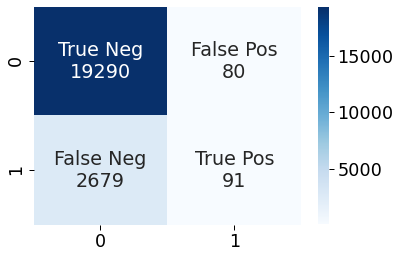

In [211]:
model.fit(X, y)
y_pred = model.predict(X_test)

probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

print(f"ROC AUC: {round(roc_auc, 6)}\n")
# Оценка качества:
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}\n'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"Расшифровка Матрицы Ошибок:")
print(f"TP, истинно положительные (дефолт классифицирован как дефолт): {cm[1,1]}")
print(f"TN, истинно отрицательные (не-дефолт классифицирован как не-дефолт): {cm[0,0]}")
print(f"FN, ложно отрицательные (дефолт классифицирован как не-дефолт): {cm[1,0]} - Bad, model, bad!!!")
print(f"FP, ложно положительные (не-дефолт классифицирован как дефолт): {cm[0,1]}")

# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')

## Пробуем oversampling

#### Функция oversample()
Берём все строки из __df__ с default=1 и добавлем к самому __df N__ раз, где __N__ - соотношение количества строк с default=0 к количеству строк с default=1

In [189]:
def oversample(df):
    defaults_0 = df[df.default == 0]
    defaults_1 = df[df.default == 1]
    N = int(len(df) / len(defaults_1))
    new_df = df
    for i in range(N):
        new_df = new_df.append(defaults_1).reset_index(drop=True)
    return new_df

In [190]:
def preprocessing_model_4(df):
    # переводим дату в datetime
    df.app_date = pd.to_datetime(df.app_date)
    
    # на этапе EDA видели, что год везде 2014, поэтому год не рассматриваем
    df['app_day'] = df.app_date.dt.day
    df['app_month'] = df.app_date.dt.month
    df['app_weekday'] = df.app_date.dt.weekday
    
    # количество дней, прошедших с начала наблюдений
    df['days'] = (df.app_date - df.app_date.min()).dt.days
    
    # выяснили раньше - app_month сильно коррелирует с days, поэтому исключаем
    # уберем столбец app_date, он нам больше не нужен
    df.drop('app_month', axis=1, inplace=True)
    df.drop('app_date', axis=1, inplace=True)
    
    # заменяем пропуски в колонке 'education' на моду
    df.education = df.education.fillna(df.education.mode()[0])
    
    # делаем 'car' категориальным: NN - нет авто, YN - российский автопром, YY - иномарка
    df.car = df.car + df.car_type
    
    # для уменьшения количества выбросов переведем в категориальный признак
    # 'decline_app_cnt' и 'bki_request_cnt' по принципу "ноль-один-два-три-много"
    df.decline_app_cnt = df.decline_app_cnt.apply(lambda x: (x if x < 10 else 10))
    df.bki_request_cnt = df.bki_request_cnt.apply(lambda x: (x if x < 10 else 10))
    
    # категоризируем возраст
    df.age = df.age.apply(age_to_cat)
    
    # Выберем из датасета нужные колонки:
    data = df[['work_address', 'home_address']].values

    # Создадим Scaler instance:
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # Из двух столбцов сделаем один путем усечения ненужной информации.
    pca = PCA(n_components=1)
    pca.fit(scaled_data)
    pca_data = pca.transform(scaled_data)
    df['address'] = pca_data
    
    # категориальные переменные кодируем при помощи OneHotEncoder()
    cats = ['address', 'sna', 'first_time', 'education', 
            'region_rating', 'car', 'decline_app_cnt', 'bki_request_cnt', 'age']
    X_cat = OneHotEncoder(sparse = False).fit_transform(df[cats].values)
        
    # бинарные переменные
    bins = ['sex', 'good_work', 'foreign_passport']

    # все бинарные колонки перекодируем прямо в датайрейме df
    le = LabelEncoder()
    for column in bins:
        le.fit(df[column])
        df[column] = le.transform(df[column])
    
    nums = ['score_bki', 'income', 'app_weekday', 'days']
   
    # логарифмирование выбранные колонки и помним, что 'score_bki' < 0
    for column in nums:
        if column in ['income']: 
            df[column] = df[column].apply(np.log1p)
    
    # cтандартизация числовых переменных - пробовал её вместо
    # логарифмирования, но модель лучше не становится
    X_num = StandardScaler().fit_transform(df[nums].values)
    
    # добавим новые полиномиальные признаки из математических
    # комбинаций числовых признаков ['score_bki', 'income', 'days']
#     pf_columns = ['score_bki', 'income', 'days']
#     pf = PolynomialFeatures(2, include_bias=False)
#     poly_data = pf.fit_transform(df[pf_columns])[:, len(pf_columns):]
#     poly_cols = pf.get_feature_names()[len(pf_columns):]
#     poly_df = pd.DataFrame(poly_data, columns=poly_cols)
#     df = df.join(poly_df, how='left')
#     X_num = np.hstack([X_num, poly_df.values])
    
    return df[bins].values, X_cat, X_num

In [203]:
# обрабатываем и разбиваем

train = pd.read_csv(path +'/train.csv')

train = oversample(train)

X_bins, X_cats, X_nums = preprocessing_model_4(train)

X = np.hstack([X_bins, X_cats, X_nums])
y = train['default'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=68)

In [204]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

print(f"ROC AUC: {round(roc_auc, 6)}\n")
# Оценка качества:
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}\n'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"Расшифровка Матрицы Ошибок:")
print(f"TP, истинно положительные (дефолт классифицирован как дефолт): {cm[1,1]}")
print(f"TN, истинно отрицательные (не-дефолт классифицирован как не-дефолт): {cm[0,0]}")
print(f"FN, ложно отрицательные (дефолт классифицирован как не-дефолт): {cm[1,0]} - Bad, model, bad!!!")
print(f"FP, ложно положительные (не-дефолт классифицирован как дефолт): {cm[0,1]}")

ROC AUC: 0.734363

accuracy_score: 0.6761
f1_score: 0.7089
recall_score: 0.732
MSE: 0.3239

[[11778  7506]
 [ 6040 16497]]
Расшифровка Матрицы Ошибок:
TP, истинно положительные (дефолт классифицирован как дефолт): 16497
TN, истинно отрицательные (не-дефолт классифицирован как не-дефолт): 11778
FN, ложно отрицательные (дефолт классифицирован как не-дефолт): 6040 - Bad, model, bad!!!
FP, ложно положительные (не-дефолт классифицирован как дефолт): 7506


In [202]:
# Обучаем модель на всём сете train
train = pd.read_csv(path +'/train.csv')

train = oversample(train)

X_bins, X_cats, X_nums = preprocessing_model_4(train)

X = np.hstack([X_bins, X_cats, X_nums])
y = train['default'].values

model = LogisticRegression()
model.fit(X, y)

test = pd.read_csv(path +'/test.csv')

# Применяем все наши манипуляции к test
test_bins, test_cats, test_nums = preprocessing_model_4(test)

test_submission = np.hstack([test_bins, test_cats, test_nums])
y_submission = model.predict_proba(test_submission)

y_submission = y_submission[:,1]

test['default'] = y_submission

submission = test[['client_id','default']]

submission.to_csv(path + '/submission_r04.csv', index=False)

# Модель с гиперпараметрами

### Используем RandomizedSearchCV. Помог данный сайт: http://espressocode.top/ml-hyperparameter-tuning/

In [76]:
train_df = df.query('sample == 1').drop(['sample','client_id'], axis=1)
test_df = df.query('sample == 0').drop(['sample','client_id'], axis=1)

In [77]:
X = train_df.drop(['default'], axis=1).values
y = train_df['default'].values # целевая переменная

In [78]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

In [79]:
param_dist = {"max_depth": [3, None],

              "max_features": randint(1, 9),

              "min_samples_leaf": randint(1, 9),

              "criterion": ["gini", "entropy"]}

In [80]:
 tree = DecisionTreeClassifier() # дерево решений

In [81]:
# Создание объекта RandomizedSearchCV
tree_cv = RandomizedSearchCV(tree, param_dist, cv = 5)

In [82]:
model_2 = tree_cv.fit(X_train, y_train)

In [83]:
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Результат: {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 2}
Результат: 0.87220311982488


Обучаем с параметрами

In [84]:
 tree = DecisionTreeClassifier(criterion='gini',max_depth=3, max_features=7, min_samples_leaf=5)

In [85]:
model_2 = tree.fit(X_train, y_train)

## Кривая ROC AUC

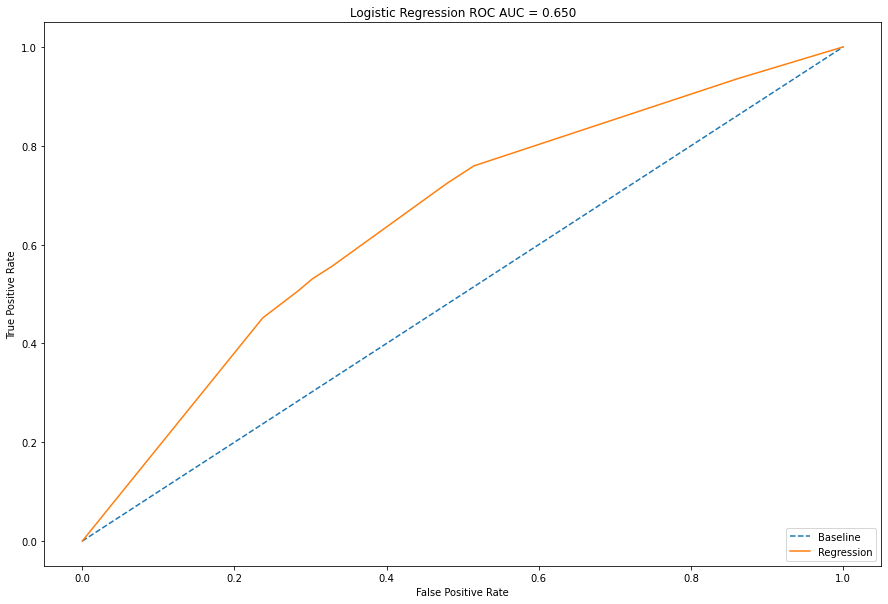

In [86]:
probs = model_2.predict_proba(X_valid)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_valid, probs)
roc_auc = roc_auc_score(y_valid, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Значение ROC AUC уменьшилось :(

### Пробуем использовать GridSearchCV

#### Код для поиска параметров подсмотрен у [данного](http://www.kaggle.com/sokolovaleks/sf-dst-10-creditscoring-golobokov-sokolov) автора

In [87]:
iter_ = 15
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

preds = model.predict(X_valid)
print('Accuracy: %.4f' % accuracy_score(y_valid, preds))
print('Precision: %.4f' % precision_score(y_valid, preds))
print('Recall: %.4f' % recall_score(y_valid, preds))
print('F1: %.4f' % f1_score(y_valid, preds))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 15
	multi_class: 'ovr'
	n_jobs: None
	penalty: 'none'
	random_state: None
	solver: 'sag'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6701
Precision: 0.2257
Recall: 0.6853
F1: 0.3396


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


### Подстраиваем параметры

In [88]:
best_model = LogisticRegression(random_state=42, C=1,  class_weight='balanced', dual=False, 
                            fit_intercept=True, intercept_scaling=1, l1_ratio=None, multi_class='auto',
                             n_jobs=None, penalty='l1', solver='saga',tol=0.001, verbose=0, warm_start=False,max_iter=1000)

best_model.fit(X_train, y_train)
y_pred_prob = best_model.predict_proba(X_valid)[:,1]
y_pred = best_model.predict(X_valid)

In [89]:
y_pred_prob

array([0.62865162, 0.57753206, 0.33041184, ..., 0.44114756, 0.46396166,
       0.34036064])

In [90]:
print('accuracy_score:',accuracy_score(y_valid,y_pred))
print('precision_score:',precision_score(y_valid,y_pred))
print('recall_score:',recall_score(y_valid,y_pred))
print('f1_score:',f1_score(y_valid,y_pred))

accuracy_score: 0.6699864498644986
precision_score: 0.22566690699351116
recall_score: 0.6852764094143404
f1_score: 0.33952542372881356


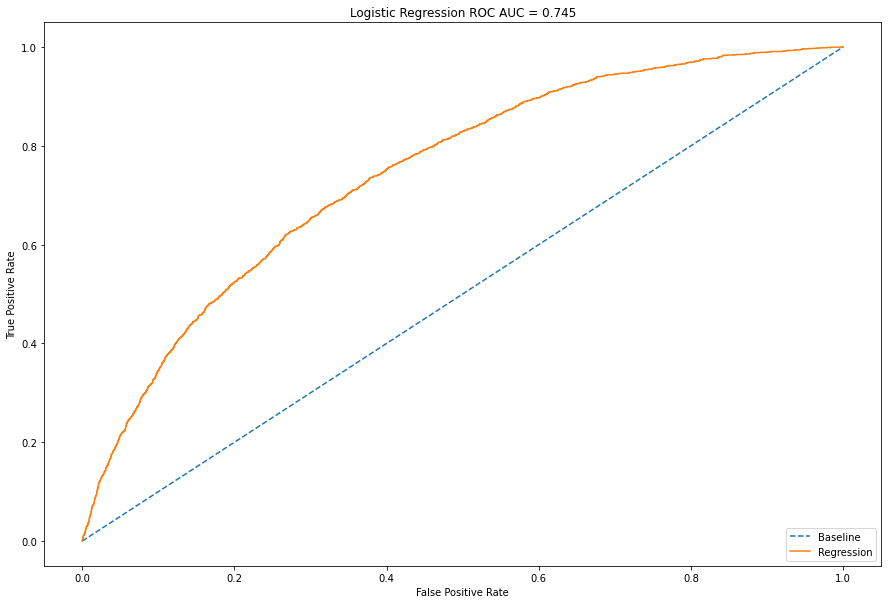

In [91]:
probs = best_model.predict_proba(X_valid)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_valid, probs)
roc_auc = roc_auc_score(y_valid, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Даже с гиперпараметрами значение ROC AUC не изменилось. Зато видно улучшение в значении некоторых метрик.

# SUBMISSION

In [92]:
train_data = data.query('sample == 1').drop(['sample','client_id'], axis=1)
test_data = data.query('sample == 0').drop(['sample','client_id'], axis=1)

In [93]:
X_train = train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [94]:
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 38), (73799, 38), (73799, 37), (73799,), (36349, 37))

In [95]:
last_model = LogisticRegression(random_state=42, C=1,  class_weight='balanced', dual=False, 
                            fit_intercept=True, intercept_scaling=1, l1_ratio=None, multi_class='auto',
                             n_jobs=None, penalty='l1', solver='saga',tol=0.001, verbose=0, warm_start=False,max_iter=1000)

last_model.fit(X_train, y_train)
y_pred_prob = last_model.predict_proba(X_test)[:,1]
y_pred = last_model.predict(X_test)

In [96]:
submit = pd.DataFrame(test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)

In [97]:
display(submit)

,client_id,default
0,74835,0.205956
1,17527,0.803475
2,75683,0.322499
3,26883,0.387106
4,28862,0.141541
...,...,...
36344,83775,0.785098
36345,106254,0.082720
36346,81852,0.790978
36347,1971,0.637193
